In [67]:
import numpy as np
import pandas as pd

#data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

#to avoid warnings
import warnings
warnings.filterwarnings('ignore')

In [68]:
train = '/Users/alexandr/Desktop/BERT/train.csv'
test ='/Users/alexandr/Desktop/BERT/test.csv'
sample_subbmission = '/Users/alexandr/Desktop/BERT/sample_submission.csv'
test_labels = '/Users/alexandr/Desktop/BERT/test_labels.csv'

In [69]:
train_data = pd.read_csv(train)
train_data.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [70]:
test_values = pd.read_csv(test)
#test_values = test_values['comment_text'].tolist()
test_values

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [71]:
test_labels = pd.read_csv(test_labels)
print(test_labels.shape)
test_labels = test_labels[
    (test_labels["toxic"] != -1) &
    (test_labels["severe_toxic"] != -1) &
    (test_labels["obscene"] != -1) &
    (test_labels["threat"] != -1) &
    (test_labels["insult"] != -1) &
    (test_labels["identity_hate"] != -1)
]

test_labels.shape

(153164, 7)


(63978, 7)

In [72]:
#assert len() == len(test_labels), "length do not equal"

In [73]:
test_data = pd.merge(test_values, test_labels, on = "id" )
test_data.shape


(63978, 8)

In [96]:
test_texts = test_data['comment_text']
test_labels = test_data.iloc[:, 2:]

In [97]:
#data = pd.read_csv(sample_subbmission)
#data.head()

In [98]:
#data = pd.read_csv(test_labels)
#data.head(10)

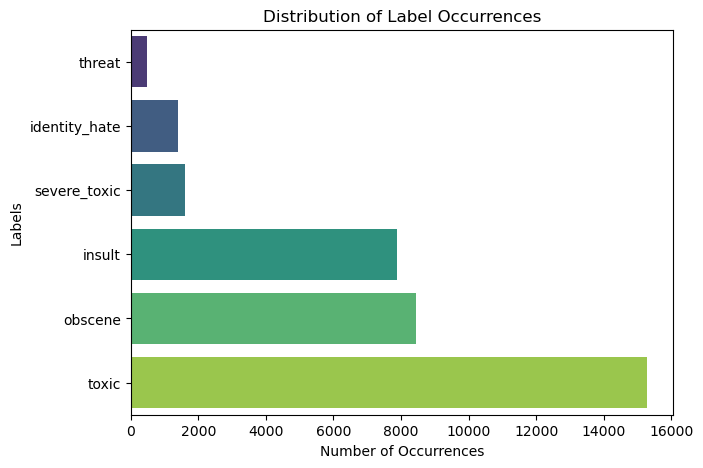

In [146]:
# Visualizing the class distribution of the 'label' column 
column_labels = train_data.columns.tolist()[2:] 
label_counts = train_data[column_labels].sum().sort_values() 


# Create a black background for the plot 
plt.figure(figsize=(7, 5)) 

# Create a horizontal bar plot using Seaborn 
ax = sns.barplot(x=label_counts.values, 
				y=label_counts.index, palette='viridis') 


# Add labels and title to the plot 
plt.xlabel('Number of Occurrences') 
plt.ylabel('Labels') 
plt.title('Distribution of Label Occurrences') 

# Show the plot 
plt.show() 



In [100]:
train_data[column_labels].sum().sort_values()

threat             478
identity_hate     1405
severe_toxic      1595
insult            7877
obscene           8449
toxic            15294
dtype: int64

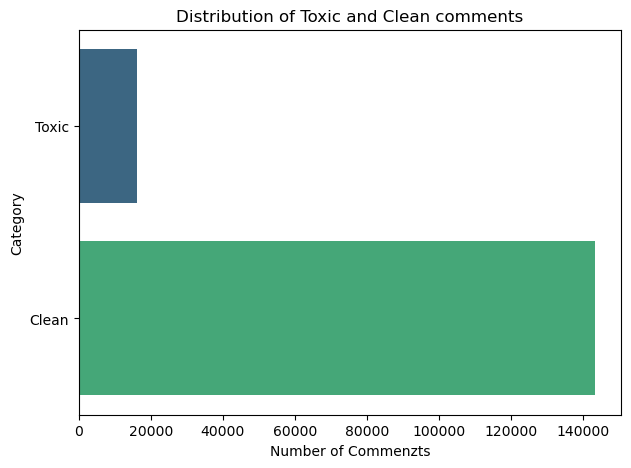

In [101]:
# Create subsets based on toxic and clean comments 
train_toxic = train_data[train_data[column_labels].sum(axis=1) > 0]
train_clean = train_data[train_data[column_labels].sum(axis=1) == 0]

# Number of toxic and clean comments
num_toxic = len(train_toxic)
num_clean = len(train_clean)

# Create DataFrame for visualisation
plot_data = pd.DataFrame(
    {'Category': ['Toxic', 'Clean'], 'Count': [num_toxic, num_clean]})

plt.figure(figsize = (7,5))

# Horizontal BAR
ax = sns.barplot(x = 'Count', y = 'Category', data = plot_data, palette = 'viridis')

plt.xlabel('Number of Commenzts')
plt.ylabel('Category')
plt.title('Distribution of Toxic and Clean comments')

ax.tick_params()
plt.show()


In [102]:
print(train_toxic.shape) 
print(train_clean.shape)

(16225, 8)
(143346, 8)


In [103]:
# Randomly sample 16225 clean comments 
train_clean_sampled = train_clean.sample(n=16225, random_state=42)

# Combine the toxic and the sampled clean comments
dataframe = pd.concat([train_toxic, train_clean_sampled], axis = 0)

#Shuffle the data to avoid any order bias during training
dataframe = dataframe.sample(frac=1, random_state = 42)


In [104]:
dataframe.shape

(32450, 8)

In [105]:
dataframe.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
57737,9a8103881a1d8372,You are an old cougar! You are an old cougar!,1,0,0,0,1,0
46617,7c9a37dc040d6ef4,I'm scared\nbrrrr.... i'm gonna die now,0,0,0,0,0,0
83356,df07677ce31a782d,"Okay, so anal sex is as widely unaccepted and ...",1,0,0,0,0,0
34637,5c854590da41ac65,shut up you cunt\nWWWWWWWWWWWWWWWWWWWWWWWWWWWW...,1,0,1,0,1,0
27887,49cfe7691eb59201,You arrogant administrator homosexual bastards...,1,1,1,0,1,1


In [106]:
# split training data into training_texts, training_labels
train_texts = dataframe.iloc[:, 1] 
train_labels = dataframe.iloc[:, 2:]

In [107]:
print(test_data.isnull().sum())  # missing data in each collumn


id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [108]:
print(test_data.iloc[:, 1].shape)  # Форма текстов
print(test_data.iloc[:, 2:].shape)  # Форма меток


(63978,)
(63978, 6)


In [109]:
# Validation set
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts,  # Тексты
    train_labels,  # Метки
    test_size=0.25,
    random_state=42
)

print(train_texts.shape)  # Количество текстов в тренировочной выборке
print(train_labels.shape)  # Метки для тренировочной выборки
print(val_texts.shape)  # Количество текстов в валидационной выборке
print(val_labels.shape)  # Метки для валидационной выборки


(24337,)
(24337, 6)
(8113,)
(8113, 6)


In [110]:
def tokenize_and_encode(tokenizer, comments, labels, max_length=128): 
    # Initialize empty lists to store tokenized inputs and attention masks 
    input_ids = [] 
    attention_masks = [] 

    # Iterate through each comment in the 'comments' list 
    for comment in comments: 
        # Tokenize and encode the comment using the BERT tokenizer 
        encoded_dict = tokenizer.encode_plus( 
            comment, 

            # Add special tokens like [CLS] and [SEP] 
            add_special_tokens=True, 

            # Truncate or pad the comment to 'max_length' 
            max_length=max_length, 

            truncation=True,

            # Pad the comment to 'max_length' with zeros if needed 
            pad_to_max_length=True, 

            # Return attention mask to mask padded tokens 
            return_attention_mask=True, 

            # Return PyTorch tensors 
            return_tensors='pt'
        ) 

        # Append the tokenized input and attention mask to their respective lists 
        input_ids.append(encoded_dict['input_ids']) 
        attention_masks.append(encoded_dict['attention_mask']) 

    # Concatenate the tokenized inputs and attention masks into tensors 
    input_ids = torch.cat(input_ids, dim=0) 
    attention_masks = torch.cat(attention_masks, dim=0) 

    # Convert the labels to a PyTorch tensor with the data type float32
    if not isinstance(labels, torch.Tensor):
        labels = torch.tensor(labels, dtype=torch.float32) 
        
    return input_ids, attention_masks, labels


   

In [111]:
# Token initialisation bert-base-uncased
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True) 

In [112]:
# Model initialisation
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6) 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [113]:
# Model initialisation roberta-base
#from transformers import AutoTokenizer, AutoModelForSequenceClassification
#tokenizer = AutoTokenizer.from_pretrained("roberta-base")
#model_roberta = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=6)

In [114]:
# Model initialisation distilbert-base-uncased
#tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
#model_distilbert = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=6)

In [115]:
# Move model to GPU if available 
device = torch.device( 
	'cuda') if torch.cuda.is_available() else torch.device('cpu') 
model = model.to(device) 


In [116]:
print(type(train_labels))
print(type(test_labels))
#val_labels = val_labels.to_numpy()
print(type(val_labels))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [122]:
# Tokenize and Encode the comments and labels for the training set 
input_ids, attention_masks, labels_tr = tokenize_and_encode( 
	tokenizer, 
	train_texts, 
	train_labels.values 
) 
print('Training Comments :',train_texts.shape) 
print('Input Ids		 :',input_ids.shape) 
print('Attention Mask :',attention_masks.shape) 
print('Labels		 :',len(labels_tr))



# Tokenize and Encode the comments and labels for the test set 
test_input_ids, test_attention_masks, labels_test = tokenize_and_encode( 
	tokenizer, 
	test_texts,
    test_labels.values
) 
print()
print('Test Comments :',test_texts.shape) 
print('Input Ids		 :',test_input_ids.shape) 
print('Attention Mask :',test_attention_masks.shape) 
print('Labels		 :',len(labels_test))



# Tokenize and Encode the comments and labels for the validation set 
val_input_ids, val_attention_masks, labels_val = tokenize_and_encode( 
	tokenizer, 
	val_texts, 
	val_labels.values
)
print()
print('Validation Comments :',val_texts.shape) 
print('Input Ids		 :',val_input_ids.shape) 
print('Attention Mask :',val_attention_masks.shape) 
print('Labels		 :', len(labels_val))

Training Comments : (24337,)
Input Ids		 : torch.Size([24337, 128])
Attention Mask : torch.Size([24337, 128])
Labels		 : 24337

Test Comments : (63978,)
Input Ids		 : torch.Size([63978, 128])
Attention Mask : torch.Size([63978, 128])
Labels		 : 63978

Validation Comments : (8113,)
Input Ids		 : torch.Size([8113, 128])
Attention Mask : torch.Size([8113, 128])
Labels		 : 8113


In [124]:
# Creating DataLoader for the balanced dataset 
batch_size = 128

train_dataset = TensorDataset(input_ids, attention_masks, labels_tr) 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 

# testing set 
test_dataset = TensorDataset(test_input_ids, test_attention_masks, labels_test) 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

# validation set 
val_dataset = TensorDataset(val_input_ids, val_attention_masks, labels_val) 
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) 


In [125]:
print('Batch Size :',train_loader.batch_size) 
Batch =next(iter(train_loader)) 
print('Each Input ids shape :',Batch[0].shape) 
print('Input ids :\n',Batch[0][0]) 
print('Corresponding Decoded text:\n',tokenizer.decode(Batch[0][0])) 
print('Corresponding Attention Mask :\n',Batch[1][0]) 
print('Corresponding Label:',Batch[2][0])


Batch Size : 128
Each Input ids shape : torch.Size([128, 128])
Input ids :
 tensor([  101,  1000,  2258,  2294,  1006, 11396,  1007,  4983,  1045,  2572,
         2200,  2172, 13534,  1010,  2017,  1006,  1998,  1010,  2116,  2060,
        15536,  3211, 15631,  1999,  2116,  3182,  1007,  2024,  2478,  1996,
        16948, 19626,  1005, 13433,  2615,  1005,  2000,  2812,  2771,  6873,
         2615,  1006,  7162,  2391,  1997,  3193,  1007,  1010,  1998,  1005,
        27937,  4492,  1005,  1006,  1005,  8699,  2391,  1997,  3193,  1005,
         1007,  2004,  4949,  4492,  1013, 14736,  6873,  2615,  1006,  3484,
         1013,  7731,  2391,  1997,  3193,  1007,  1012,  2003,  2045,  1037,
         7337,  2012, 16948, 13557,  2057,  2064,  2130,  5323,  2054,  2003,
         1996,  4949,  4492,  1029,  1000,  1000,  2017,  2024,  2214,  1010,
         2269,  2520,  1010,  1000,  1000,  1996,  2402,  2158,  2056,  1010,
         1000,  1000,  1998,  2115,  2606,  2038,  2468,  2200,  2

In [126]:
# Optimizer setup 
optimizer = AdamW(model.parameters(), lr=2e-5)


In [127]:
# WE NEED TO MAKE A LOOP TO TRAIN 3 DIFFERENT MODELS

In [128]:
# Function to Train the Model 
def train_model(model, train_loader, optimizer, device, num_epochs): 
	# Loop through the specified number of epochs 
	for epoch in range(num_epochs): 
		# Set the model to training mode 
		model.train() 
		# Initialize total loss for the current epoch 
		total_loss = 0

		# Loop through the batches in the training data 
		for batch in train_loader: 
			input_ids, attention_mask, labels = [t.to(device) for t in batch] 

			optimizer.zero_grad() 

			outputs = model( 
				input_ids, attention_mask=attention_mask, labels=labels) 
			loss = outputs.loss 
			total_loss += loss.item() 

			loss.backward() 
			optimizer.step() 

		model.eval() # Set the model to evaluation mode 
		val_loss = 0

		# Disable gradient computation during validation 
		with torch.no_grad(): 
			for batch in val_loader: 
				input_ids, attention_mask, labels = [ 
					t.to(device) for t in batch] 

				outputs = model( 
					input_ids, attention_mask=attention_mask, labels=labels) 
				loss = outputs.loss 
				val_loss += loss.item() 
		# Print the average loss for the current epoch 
		print( 
			f'Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader)},Validation loss:{val_loss/len(val_loader)}') 


# Call the function to train the model 
train_model(model, train_loader, optimizer, device, num_epochs=7) 


Epoch 1, Training Loss: 0.2755439913397684,Validation loss:0.1787948734126985
Epoch 2, Training Loss: 0.16372515272875732,Validation loss:0.15493579499889165
Epoch 3, Training Loss: 0.13996597270222857,Validation loss:0.15464005060493946


Accuracy: 0.6999
Precision: 0.7903
Recall: 0.8802
Confusion Matrices for Each Class:
Class 0:
[[3716  574]
 [ 115 3708]]
Class 1:
[[7496  196]
 [ 225  196]]
Class 2:
[[5528  490]
 [ 207 1888]]
Class 3:
[[7976   16]
 [  91   30]]
Class 4:
[[5470  666]
 [ 285 1692]]
Class 5:
[[7680  105]
 [ 127  201]]


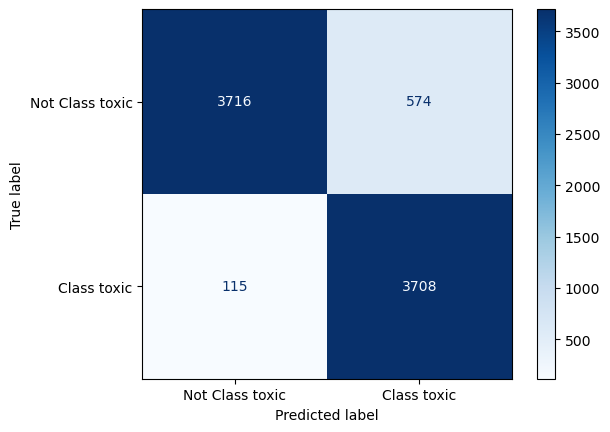

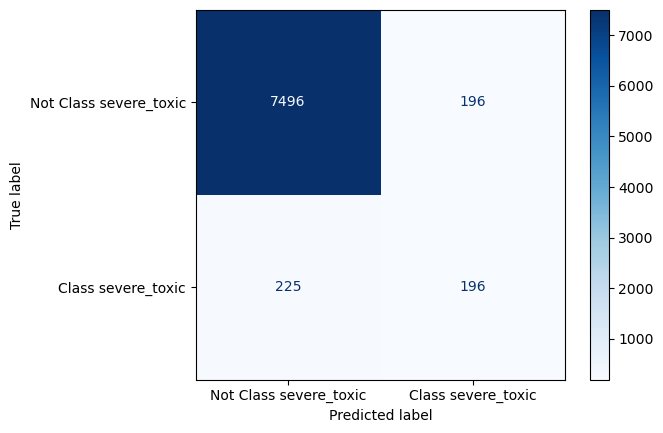

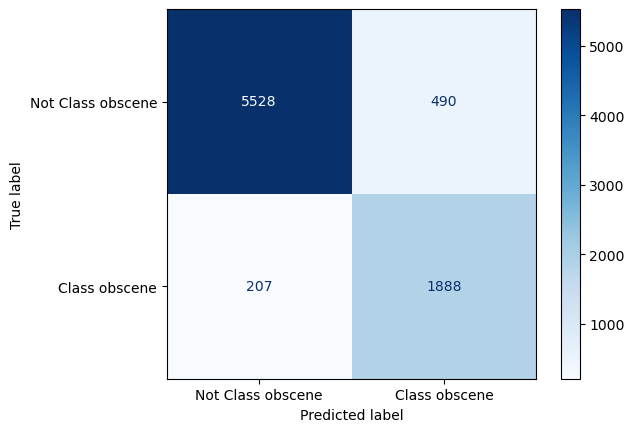

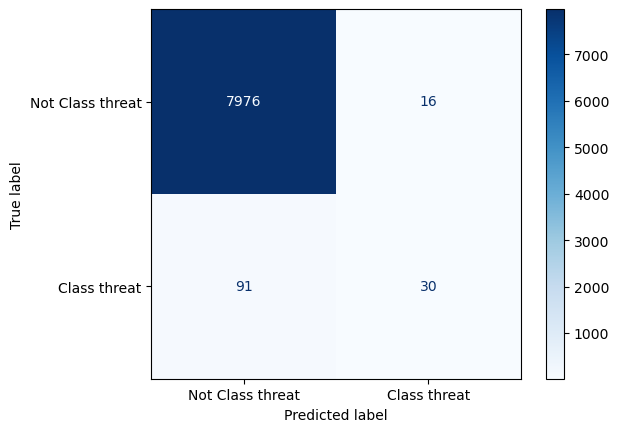

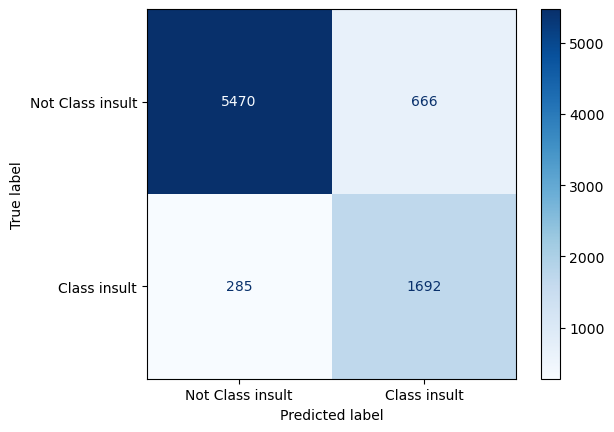

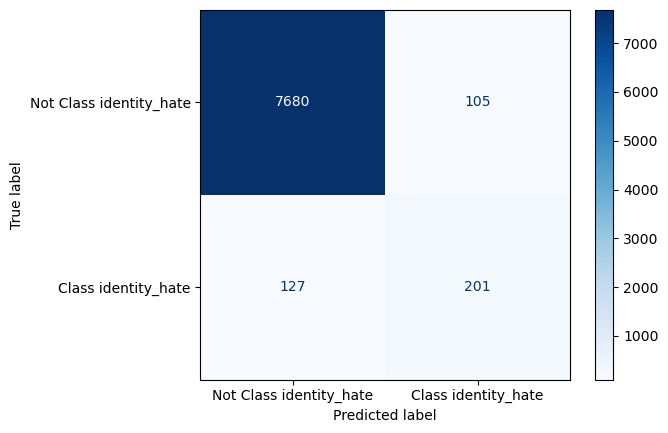

In [147]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, multilabel_confusion_matrix, ConfusionMatrixDisplay
columns = ["toxic",	"severe_toxic",	"obscene",	"threat",	"insult",	"identity_hate"]
# Evaluate the Model
def evaluate_model(model, val_loader, device): 
    model.eval()  # Set the model to evaluation mode 

    true_labels = [] 
    predicted_probs = [] 

    with torch.no_grad(): 
        for batch in val_loader: 
            input_ids, attention_mask, labels = [t.to(device) for t in batch] 

            # Get model's predictions 
            outputs = model(input_ids, attention_mask=attention_mask) 
            # Use sigmoid for multilabel classification 
            predicted_probs_batch = torch.sigmoid(outputs.logits) 
            predicted_probs.append(predicted_probs_batch.cpu().numpy()) 

            true_labels_batch = labels.cpu().numpy() 
            true_labels.append(true_labels_batch) 

    # Combine predictions and labels for evaluation 
    true_labels = np.concatenate(true_labels, axis=0) 
    predicted_probs = np.concatenate(predicted_probs, axis=0) 
    predicted_labels = (predicted_probs > 0.5).astype(int)  # Apply threshold for binary classification 

    # Calculate evaluation metrics 
    accuracy = accuracy_score(true_labels, predicted_labels) 
    precision = precision_score(true_labels, predicted_labels, average='micro') 
    recall = recall_score(true_labels, predicted_labels, average='micro')
    conf_matrix = multilabel_confusion_matrix(true_labels, predicted_labels)

    # Print the evaluation metrics 
    print(f'Accuracy: {accuracy:.4f}') 
    print(f'Precision: {precision:.4f}') 
    print(f'Recall: {recall:.4f}')
    print(f'Confusion Matrices for Each Class:')
    for i, matrix in enumerate(conf_matrix):
        print(f"Class {i}:\n{matrix}")

    for i, matrix in enumerate(conf_matrix):
        disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=[f'Not Class {columns[i]}', f'Class {columns[i]}'])
        disp.plot(cmap='Blues')

# Call the function to evaluate the model on the test data 
evaluate_model(model, val_loader, device)


In [130]:
# Dirrectory for the model
model_save_path = "./saved_model_second_try"

# Save the model and tokenizer
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)


('./saved_model_second_try/tokenizer_config.json',
 './saved_model_second_try/special_tokens_map.json',
 './saved_model_second_try/vocab.txt',
 './saved_model_second_try/added_tokens.json')

In [131]:
# Load the tokenizer and model from the saved directory 
model_name = model_save_path
Bert_Tokenizer = BertTokenizer.from_pretrained(model_name) 
Bert_Model = BertForSequenceClassification.from_pretrained( 
	model_name).to(device) 


In [134]:
def predict_user_input(input_text, model=Bert_Model, tokenizer=Bert_Tokenizer, device=device): 
	user_input = [input_text] 

	user_encodings = tokenizer( 
		user_input, truncation=True, padding=True, return_tensors="pt") 

	user_dataset = TensorDataset( 
		user_encodings['input_ids'], user_encodings['attention_mask']) 

	user_loader = DataLoader(user_dataset, batch_size=1, shuffle=False) 

	model.eval() 
	with torch.no_grad(): 
		for batch in user_loader: 
			input_ids, attention_mask = [t.to(device) for t in batch] 
			outputs = model(input_ids, attention_mask=attention_mask) 
			logits = outputs.logits 
			predictions = torch.sigmoid(logits) 

	predicted_labels = (predictions.cpu().numpy() > 0.5).astype(int) 
	labels_list = ['toxic', 'severe_toxic', 'obscene', 
				'threat', 'insult', 'identity_hate'] 
	result = dict(zip(labels_list, predicted_labels[0])) 
	return result 


text = 'Are you insane!'
#predict_user_input(input_text=text) 
print(predict_user_input(input_text=text) )

#predict_user_input(input_text='How are you?') 
print(predict_user_input(input_text='How are you?') )

text = "Such an Idiot person"
predict_user_input(model=Bert_Model, 
				tokenizer=Bert_Tokenizer, 
				input_text=text, 
				device=device) 


{'toxic': 1, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}
{'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}


{'toxic': 1,
 'severe_toxic': 0,
 'obscene': 1,
 'threat': 0,
 'insult': 1,
 'identity_hate': 0}

Accuracy: 0.7790
Precision: 0.4301
Recall: 0.8841
Confusion Matrices for Each Class:
Class 0:
[[46799 11089]
 [   82  6008]]
Class 1:
[[63206   405]
 [  133   234]]
Class 2:
[[57383  2904]
 [  474  3217]]
Class 3:
[[63726    41]
 [  145    66]]
Class 4:
[[58342  2209]
 [  573  2854]]
Class 5:
[[62934   332]
 [  274   438]]


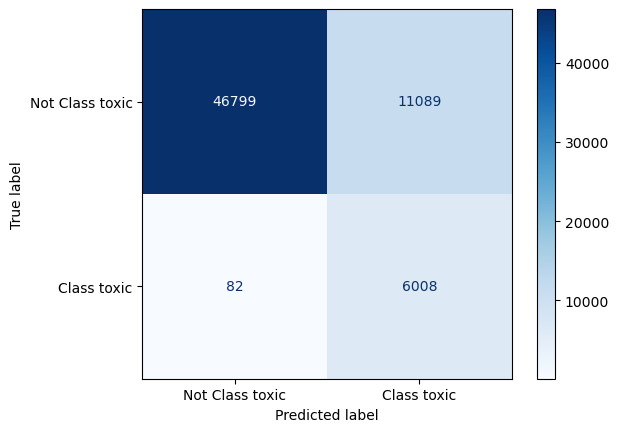

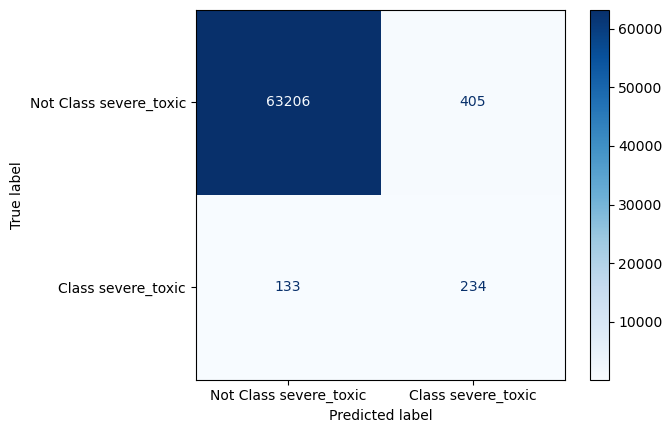

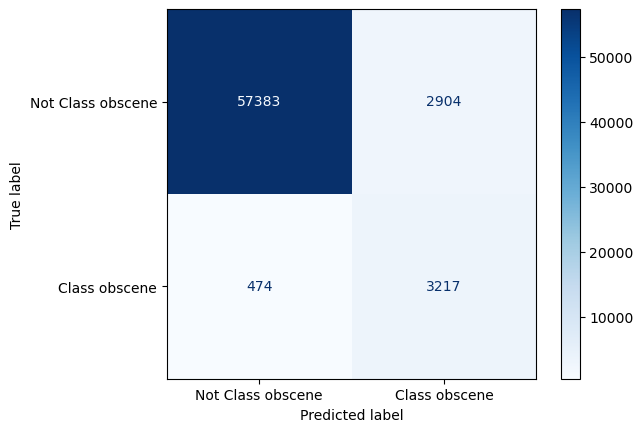

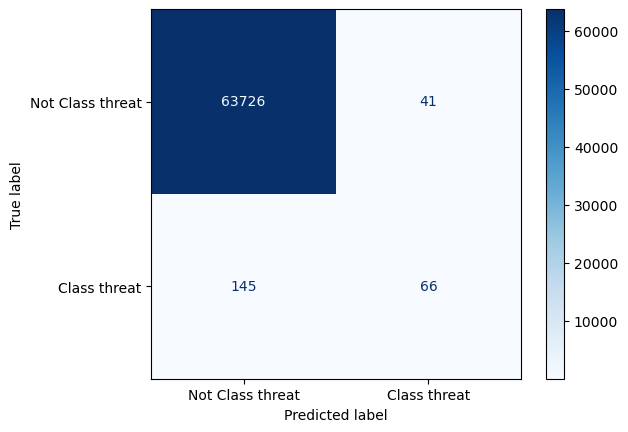

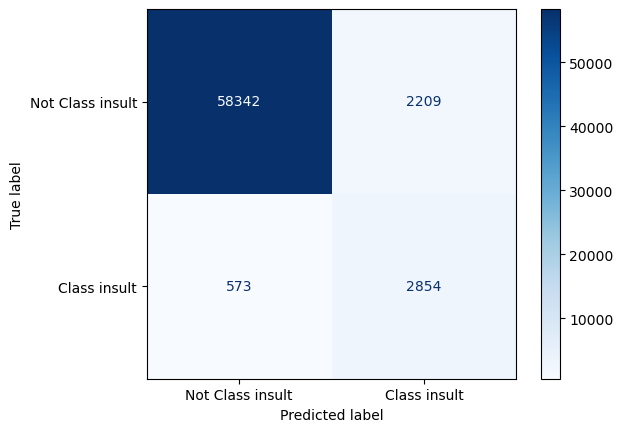

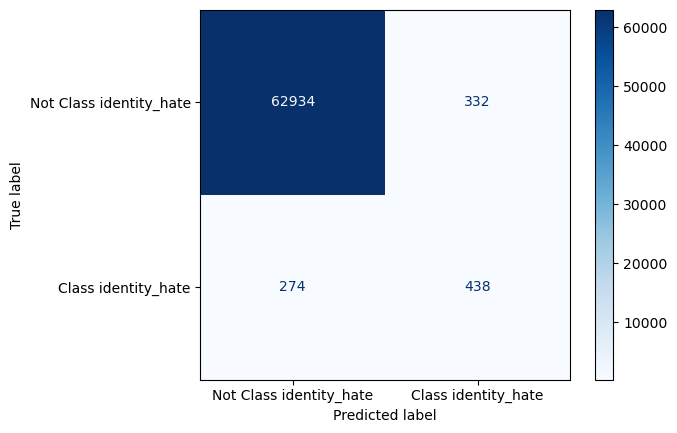

In [148]:
# Model evaluation on the test data
evaluate_model(model, test_loader, device)